## Imports, EDA & Feature Engineering

In [270]:
# !pip install feature_engine
# !pip install catboost

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt

import scipy.stats as stats
import pylab

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import catboost as cat

import warnings
warnings.filterwarnings('ignore')
from google.colab import files

In [350]:
df_train = pd.read_csv('train_fNxu4vz.csv')
df_test = pd.read_csv('test_fjtUOL8.csv')
df_sample = pd.read_csv('sample_submission_HSqiq1Q.csv')

In [230]:
df_train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


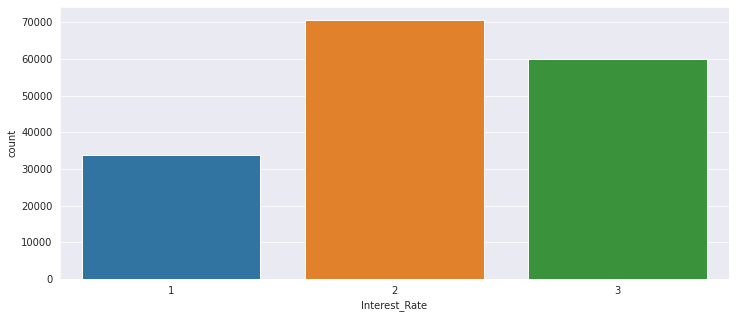

In [268]:
plt.figure(figsize=(12,5))
sns.countplot(df_train['Interest_Rate'])

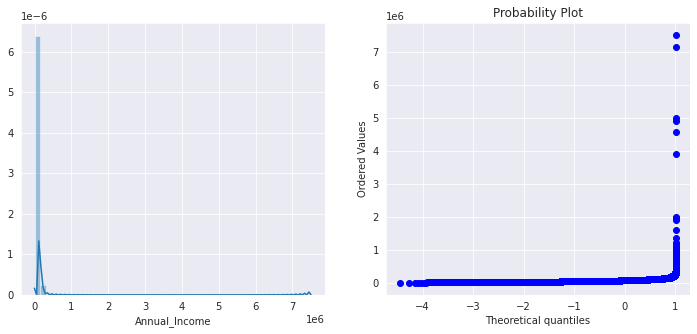

In [242]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.distplot(df_train['Annual_Income'])
plt.subplot(1,2,2)
stats.probplot((df_train['Annual_Income']),plot =pylab)
plt.show()

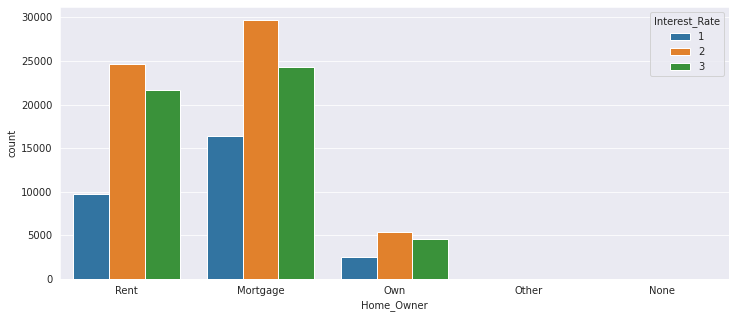

In [244]:
plt.figure(figsize=(12,5))
sns.countplot(df_train['Home_Owner'],hue=df_train['Interest_Rate'])

<function matplotlib.pyplot.tight_layout>

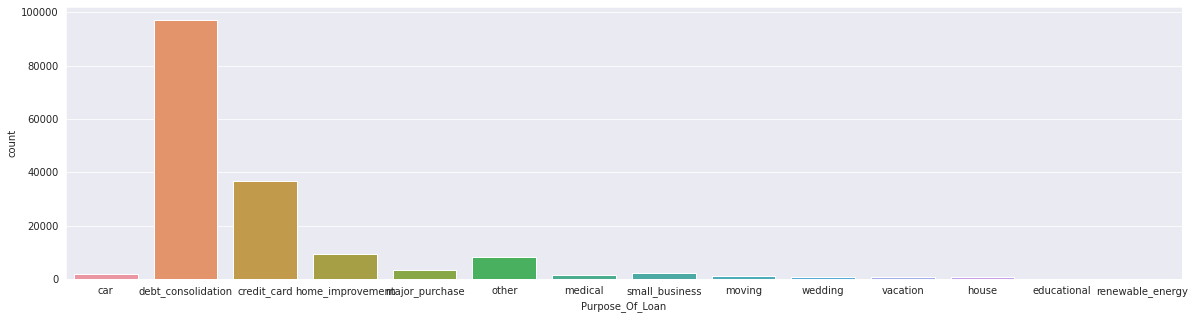

In [258]:
plt.figure(figsize=(20,5))
sns.countplot(df_train['Purpose_Of_Loan'])
plt.tight_layout

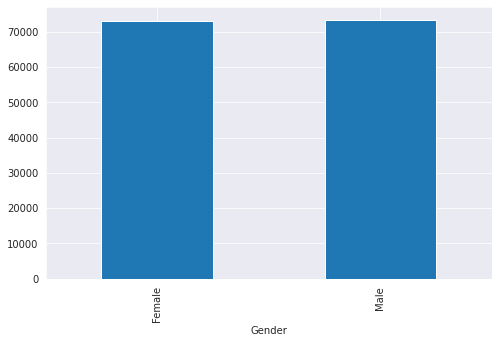

In [269]:
plt.figure(figsize=(8,5))
df_train.groupby('Gender')['Annual_Income'].mean().plot.bar()

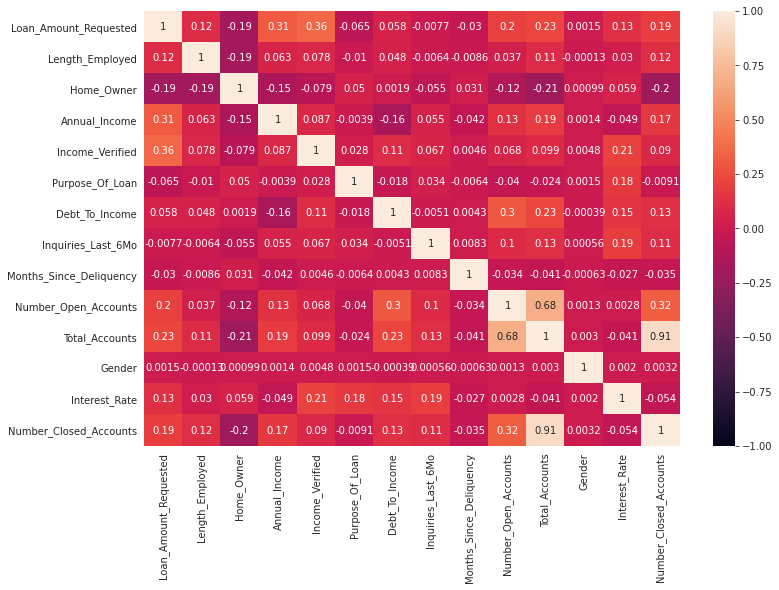

In [89]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.corr(),vmax=1,vmin=-1,annot=True)

In [6]:
print(len(df_train))
print()
print(df_train.isnull().sum())

164309

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  int64  
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

In [351]:
def output(model,data,name):

  pred = pd.Series((model.predict(data)).reshape(-1,))
  final_df = pd.concat([df_sample['Loan_ID'],pred],axis =1)
  final_df.columns = df_sample.columns
  final_df.to_csv(name,index = False)
  files.download(name)

In [352]:
drop_list = ['Loan_ID']
num_mean = ['Annual_Income','Months_Since_Deliquency']
num_median = ['Length_Employed',]
cat_mode = ['Home_Owner']
num_yeo = ['Loan_Amount_Requested','Annual_Income']
cat_enc = ['Home_Owner','Income_Verified','Purpose_Of_Loan','Gender']

In [353]:
map_length_employed = {'< 1 year':0.5, '4 years':4, '7 years':7, '8 years':8, '2 years':2, '10+ years':10, '1 year':1, '6 years':6, '9 years':9, '3 years':3, '5 years':5}
df_train['Length_Employed'] = df_train['Length_Employed'].map(map_length_employed)
df_test['Length_Employed'] = df_test['Length_Employed'].map(map_length_employed)

In [354]:
df_train['Home_Owner'] = df_train['Home_Owner'].replace('None','Other')
df_test['Home_Owner'] = df_test['Home_Owner'].replace('None','Other')

In [355]:
df_train['Loan_Amount_Requested'] = df_train['Loan_Amount_Requested'].apply(lambda x: eval(''.join(x.split(','))))
df_test['Loan_Amount_Requested'] = df_test['Loan_Amount_Requested'].apply(lambda x: eval(''.join(x.split(','))))

In [356]:
df_train['Number_Closed_Accounts'] = df_train['Total_Accounts'] - df_train['Number_Open_Accounts']
df_test['Number_Closed_Accounts'] = df_test['Total_Accounts'] - df_test['Number_Open_Accounts']

In [357]:
df_train['Income_Verified'] = df_train['Income_Verified'].replace('VERIFIED - income source','VERIFIED - income') 
df_test['Income_Verified'] = df_test['Income_Verified'].replace('VERIFIED - income source','VERIFIED - income')

In [358]:
df_train.drop(drop_list,axis=1,inplace=True)
df_test.drop(drop_list,axis=1,inplace=True)

In [359]:
X = df_train.drop('Interest_Rate',axis =1)
y = df_train['Interest_Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify =y)

In [360]:
pipe = Pipeline([
                 ('mean', mdi.MeanMedianImputer(imputation_method='mean',variables = num_mean)),
                 ('median',mdi.MeanMedianImputer(imputation_method='median',variables=num_median)),
                 ('mode',mdi.CategoricalVariableImputer(imputation_method='missing',variables=cat_mode)),
                 ('enc',ce.OneHotCategoricalEncoder(drop_last=True,variables=cat_enc))
])

X_train = pipe.fit_transform(X_train,y_train)
X_test = pipe.transform(X_test)
df_test = pipe.transform(df_test)

In [361]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
df_test = scale.transform(df_test)

## Random Forest Classifier

In [72]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train,y_train)
pred_rfc = model_rfc.predict(X_test)
print('F1 Score: ',f1_score(y_test,pred_rfc,average='weighted'))
print('Accuracy Score: ',accuracy_score(y_test,pred_rfc))
print('Classification Report: ')
print(classification_report(y_test,pred_rfc))

F1 Score:  0.5057105840980555
Accuracy Score:  0.515639408358231
Classification Report:                precision    recall  f1-score   support

           1       0.48      0.26      0.33     11068
           2       0.49      0.61      0.54     23270
           3       0.56      0.55      0.56     19884

    accuracy                           0.52     54222
   macro avg       0.51      0.47      0.48     54222
weighted avg       0.52      0.52      0.51     54222



## XGB Classifier

In [99]:
model_xgb = xgb.XGBRFClassifier()
model_xgb.fit(X_train,y_train)
pred_xgb = model_xgb.predict(X_test)
print('F1 Score: ',f1_score(y_test,pred_xgb,average='weighted'))
print('Accuracy Score: ',accuracy_score(y_test,pred_xgb))
print('Classification Report: ')
print(classification_report(y_test,pred_xgb))

F1 Score:  0.43875486180988554
Accuracy Score:  0.4956106377485154
Classification Report: 
              precision    recall  f1-score   support

           1       0.38      0.00      0.01     11068
           2       0.47      0.70      0.57     23270
           3       0.54      0.53      0.53     19884

    accuracy                           0.50     54222
   macro avg       0.46      0.41      0.37     54222
weighted avg       0.48      0.50      0.44     54222



## Cat Boost Classifier

In [362]:
model_cat = cat.CatBoostClassifier(verbose=0,depth = 8,iterations = 100,learning_rate= 0.1)
model_cat.fit(X_train,y_train)
pred_cat = model_cat.predict(X_test)
print('F1 Score: ',f1_score(y_test,pred_cat,average='weighted'))
print('Accuracy Score: ',accuracy_score(y_test,pred_cat))
print('Classification Report: ')
print(classification_report(y_test,pred_cat))

F1 Score:  0.518647378423058
Accuracy Score:  0.5321640662461732
Classification Report: 
              precision    recall  f1-score   support

           1       0.54      0.24      0.33     11156
           2       0.50      0.65      0.56     23291
           3       0.59      0.56      0.57     19775

    accuracy                           0.53     54222
   macro avg       0.54      0.48      0.49     54222
weighted avg       0.54      0.53      0.52     54222



In [287]:
search = {'depth': [6,8,10], 'learning_rate': [0.01, 0.05, 0.1], 'iterations': [30, 50, 100]}
search = GridSearchCV(estimator = model_cat,param_grid= search,n_jobs=-1)
search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f852a2235f8>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [288]:
search.best_params_

{'depth': 8, 'iterations': 100, 'learning_rate': 0.1}

In [363]:
output(model_cat,df_test,'Cat_7.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>